In [1]:
import os 
os.listdir()

['spec_check&add_target.ipynb',
 'Impute_Missing_Value.ipynb',
 'second_model.ipynb',
 'xgb_importance.png',
 'data',
 'train.csv',
 'EDA.ipynb',
 'XgboostModeling.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'LSTM.ipynb',
 'train_FeatureSelected.csv',
 'feature select.ipynb',
 'tpot_pa_pipeline.py',
 'TPOT.ipynb',
 'three_model.ipynb',
 'cnn-time-stack.ipynb',
 '.ipynb_checkpoints']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from tqdm import tqdm_notebook as tqdm

# load

In [3]:
chmap = pd.read_excel('tag盤點表.xlsx')[['TAG','chinese']]
chmap = dict(zip(chmap['TAG'],chmap['chinese']))

In [4]:
df = pd.read_csv('./data/train_spec_checked(full).csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(193824, 36)


,MLPAP_TI-0706B03,MLPAP_TI-0706B07,MLPAP_TI-0706B20,MLPAP_TI-0706B14,MLPAP_LIC-0738.PV,MLPAP_TI-0706B11,MLPAP_TI-0706B19,MLPAP_TIC-0757.PV,DATA OF USE,MLPAP_TI-0706B04,...,MLPAP_TI-0706E01,MLPAP_TI-0706B06,MLPAP_TI-0706B17,MLPAP_TI-0706B24,MLPAP_TRC-0610.PV,MLPAP_FR-0755.PV,MLPAP_TJR-0715A1.PV,over_range_num,target,target_over_range
2016-05-09 00:00:00,401.962157,400.998932,400.795492,402.997679,23.912053,400.999089,402.998548,1.635430,3.342795,400.757148,...,400.994908,401.143639,401.951886,401.997668,199.928694,4.050917,402.689070,4,NaN,1
2016-05-09 00:10:00,401.939352,400.998932,400.795492,403.098684,23.912053,400.999089,402.998548,1.624784,3.342795,400.954632,...,400.994908,401.004025,401.830477,401.997668,199.928694,4.157893,402.778582,4,NaN,1
2016-05-09 00:20:00,401.905143,400.998932,400.751502,402.997679,23.912053,400.999089,402.998548,1.649624,3.342795,400.896549,...,400.994908,401.004025,401.764254,401.997668,199.928694,4.207893,402.728853,4,NaN,1
2016-05-09 00:30:00,401.950754,400.998932,400.949457,403.098684,23.912053,400.999089,402.998548,1.635430,3.342795,400.896549,...,400.994908,401.004025,401.996035,401.997668,199.928694,4.152079,403.166466,4,NaN,1
2016-05-09 00:40:00,401.996366,400.998932,401.004445,403.098684,23.912053,400.999089,402.998548,1.653172,3.342795,400.850082,...,400.994908,401.004025,401.709068,401.997668,199.928694,4.016615,403.017280,4,NaN,1


# select date

In [5]:
#以下選一個
#'2016-05-09':'2017-05-09'
#'2017-05-09':'2018-05-09'
#'2018-05-09':'2019-05-09'

In [6]:
df = df.loc['2016-05-09':'2017-05-09']
print(df.shape)

(52704, 36)


# define columns

In [7]:
x_col = df.drop(['target','target_over_range','over_range_num'],axis=1).columns.tolist()
y_col = 'target'

# threshold

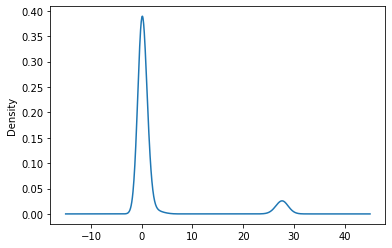

In [8]:
df['over_range_num'].plot(kind='kde')

In [9]:
df['over_range_num'].describe()

count    52704.000000
mean         2.427880
std          7.438917
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         30.000000
Name: over_range_num, dtype: float64

In [10]:
threshold = df['over_range_num'].median()
print(threshold)

0.0


# create X,y pair

In [11]:
def train_windows(df, ref_day):
    X_train, Y_train, i_lst = [], [], []
    for i in tqdm(range(len(df)-ref_day)):
        # 起始日,結束日
        start,end = i,i+ref_day
        # 篩選條件
        C1 = (df.iloc[start:end+1]['target_over_range'].sum() == 0) # 所有日子的y都要正常
        #C2 = (df.iloc[start:end+1]['over_range_num'].mean() <= threshold) # 所有日子的X其平均小於等於threshold
        if C1: 
            X_train.append(df.iloc[start:end][x_col+[y_col]].values) #不包含最後一天的X和y
            Y_train.append(df.iloc[end][y_col]) #一個標量,最後一天的Y
            i_lst.append(df.iloc[[end]].index[0]) #一個時間戳記,最後一天的日期
    # 重整格式
    X_train = np.array(X_train) #一個3Darray
    Y_train = pd.Series(Y_train,index=i_lst,name='y') #一個時間序列
    return X_train, Y_train

In [12]:
X, y = train_windows(df,ref_day=6)
print(X.shape,y.shape)

/workspace/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



(35610, 6, 34) (35610,)


# reshape

In [13]:
TIME_PERIODS,num_sensors = X[0].shape
input_shape = TIME_PERIODS*num_sensors
X = X.reshape(-1,input_shape)
print(TIME_PERIODS,num_sensors)
print(input_shape)
print(X.shape,y.shape)

6 34
204
(35610, 204) (35610,)


# split

In [14]:
train_len = int(len(X)*0.8)
X_train,X_test = X[:train_len],X[train_len:]
y_train,y_test = y[:train_len],y[train_len:]
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(28488, 204) (28488,)
(7122, 204) (7122,)


# fit

In [15]:
model = XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)

/workspace/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/workspace/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

# evaluate test data

In [16]:
from sklearn.metrics import mean_squared_error,r2_score

y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred,name='y_pred',index=y_test.index)

eval_res = pd.DataFrame(index=['TIME_PERIODS_{}'.format(TIME_PERIODS)],columns=['R2','MSE'])
eval_res.loc[:,'R2'] = r2_score(y_test,y_pred)
eval_res.loc[:,'MSE'] = mean_squared_error(y_test,y_pred)
eval_res

,R2,MSE
TIME_PERIODS_6,0.94199,4.08035e-06


# plot importances

In [17]:
def plot_imp_2D(model):
    
    # 2D
    imp2d = np.array([round(x,4) for x in model.feature_importances_]).reshape(TIME_PERIODS,num_sensors)
    imp2d = pd.DataFrame(imp2d,columns=x_col+[y_col])
    
    # 1D
    imp1d = pd.DataFrame()
    imp1d['TAG'] = x_col+[y_col]
    imp1d['chinese'] = imp1d['TAG'].map(chmap)
    imp1d['importance'] = imp2d.sum(axis=0).values
    imp1d = imp1d.sort_values(by='importance',ascending=False)
    
    return imp2d,imp1d

In [18]:
imp2d,imp1d = plot_imp_2D(model)

In [19]:
imp2d.style.background_gradient()

,MLPAP_TI-0706B03,MLPAP_TI-0706B07,MLPAP_TI-0706B20,MLPAP_TI-0706B14,MLPAP_LIC-0738.PV,MLPAP_TI-0706B11,MLPAP_TI-0706B19,MLPAP_TIC-0757.PV,DATA OF USE,MLPAP_TI-0706B04,MLPAP_TI-0716D01,MLPAP_TI-0706B13,MLPAP_TI-0706B10,MLPAP_PIC-0761.PV,MLPAP_TI-0706B22,MLPAP_TIC-1721.PV,MLPAP_TI-0706B09,MLPAP_TI-0706B05,MLPAP_V125-PHD,MLPAP_TI-0706B02,MLPAP_TRC-1734.PV,MLPAP_TI-0706B18,MLPAP_TI-0706B08,MLPAP_TI-0706A01,MLPAP_TI-0706B16,MLPAP_TI-0706B23,MLPAP_TI-0706E01,MLPAP_TI-0706B06,MLPAP_TI-0706B17,MLPAP_TI-0706B24,MLPAP_TRC-0610.PV,MLPAP_FR-0755.PV,MLPAP_TJR-0715A1.PV,target
0,0.0028,0.0015,0.0006,0,0.0019,0,0,0.001,0.0004,0.0032,0,0,0,0.0072,0.0027,0.0015,0.0045,0.0029,0,0.0013,0.0031,0,0.0039,0,0,0.0025,0.0013,0.002,0,0.0026,0.0025,0.0028,0.0003,0.0325
1,0,0,0,0,0.0003,0,0,0.0021,0,0,0,0,0,0.0017,0,0.0026,0,0,0,0.006,0.0053,0,0.0036,0,0,0,0.0026,0,0,0,0,0.0004,0,0.0404
2,0.0012,0,0,0,0.0018,0,0,0.0006,0,0.0016,0,0,0,0.0002,0.0011,0.0036,0,0.0027,0,0.0024,0.0007,0,0,0.0007,0.0014,0,0,0,0,0.0027,0,0.001,0,0.0021
3,0.0014,0.0014,0,0,0.0008,0,0,0.0014,0,0.004,0,0,0.0101,0.0006,0.0036,0.0033,0,0.0023,0,0,0.0039,0,0.0024,0,0.0027,0.0028,0,0.0021,0,0.0029,0.0034,0.0024,0.0023,0.003
4,0.0069,0,0,0,0.0019,0,0,0.0042,0,0.0029,0,0,0,0,0,0,0,0,0,0,0.0016,0,0,0,0,0,0,0,0.0015,0.0019,0.0014,0.0014,0,0.0046
5,0.0019,0.0029,0,0.0019,0,0,0,0,0,0.0057,0.0014,0,0,0.0001,0.0012,0.0029,0.0017,0.0042,0,0,0,0,0.0028,0,0.002,0.0024,0.004,0.0035,0,0.0035,0.0017,0.004,0.0006,0.693


In [23]:
imp1d.head(10).fillna('上個時間點的target').style.background_gradient()

,TAG,chinese,importance
33,target,上個時間點的target,0.7756
9,MLPAP_TI-0706B04,反應槽溫度_多點式(高度 450),0.0174
20,MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,0.0146
0,MLPAP_TI-0706B03,反應槽溫度_多點式(高度 350),0.0142
15,MLPAP_TIC-1721.PV,轉換式冷凝器冷油溫度,0.0139
29,MLPAP_TI-0706B24,反應槽溫度_多點式(高度 2450),0.0136
22,MLPAP_TI-0706B08,反應槽溫度_多點式(高度 850),0.0127
17,MLPAP_TI-0706B05,反應槽溫度_多點式(高度 550),0.0121
31,MLPAP_FR-0755.PV,反應槽16K蒸氣輸出,0.012
12,MLPAP_TI-0706B10,反應槽溫度_多點式(高度 1050),0.0101


# plot line

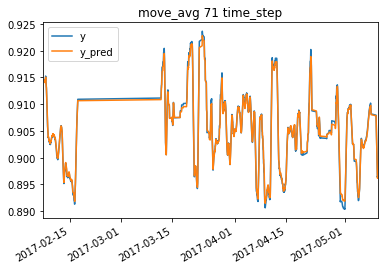

In [21]:
n = int(len(y_pred)/100)

y_test.sort_index().rolling(n).mean().plot()
y_pred.sort_index().rolling(n).mean().plot()

plt.legend()
plt.title('move_avg {} time_step'.format(n))
plt.show()

Text(0, 0.5, 'R2')

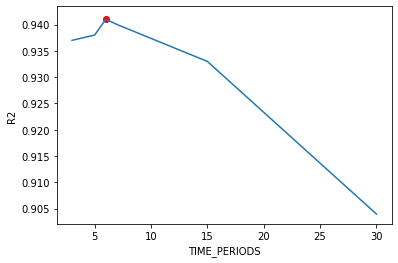

In [22]:
x = [3,5,6,7,15,30]
y = [0.937,0.938,0.941,0.940,0.933,0.904]
plt.plot(x,y)
plt.scatter(x[2],y[2],color='red')
plt.xlabel('TIME_PERIODS')
plt.ylabel('R2')